The goal of this notebook is to gather common methods for differentiation for comparison across a suite of examples. 

References:


[1] Numerical differentiation of experimental data: local versus global methods, K. Ahnert and M. Abel  
[2] An Algorithm for Total Variation Minimization and Applications, Antonin Chambolle  
[3] A Direct Algorithm for 1D Total Variation Denoising, Laurent Condat  

TODO:
- Add optimization and change derivatives to compute optimal parameters before plotting
- Add support for standard spectral filters in spectral derivatives
- Add Sobolev gradient
- Derivatives using JAX or other automatic differentiation tool with python natives

# Load

In [119]:
%matplotlib inline

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
from scipy import interpolate, fftpack, integrate, stats, sparse
import warnings

In [121]:
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['scatter.marker'] = '.'

In [195]:
from importlib import import_module, reload
from sys import path

In [191]:
diff = import_module('differentiation')

In [192]:
diff = reload(diff)

# Examples

In [8]:
def plot_example(diff_method, t, data_f, res_f, sigmas):
    fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
    indices = np.arange(len(t))
    
    for axs, s in zip(ax, sigmas):
        res = list(diff_method.compute_for(t, data_f(t, s), indices))
        axs.plot(t, res)
        axs.plot(t, res_f(t))
        axs.set_title("Noise: $\sigma$={}".format(s))

## Example 1: Sine

In [179]:
def noisy_sin(x, sigma):
    '''Sine with gaussian noise.'''
    return np.sin(x) + np.random.normal(loc=0, scale=sigma, size=x.shape)

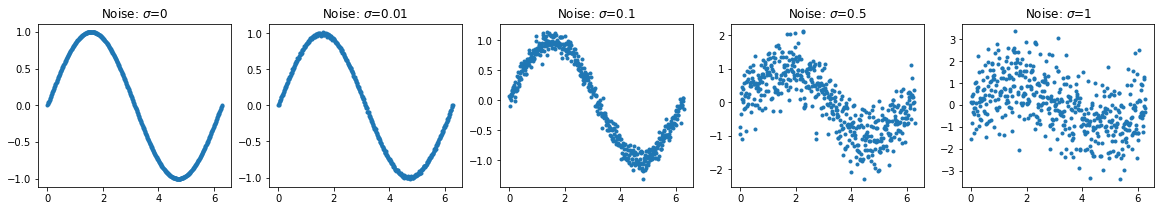

In [180]:
sigmas = [0, 0.01, 0.1, .5, 1]
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])

x = np.linspace(0, 2*np.pi, 500)
for axs, s in zip(ax, sigmas): 
    axs.scatter(x, noisy_sin(x, s))
    axs.set_title("Noise: $\sigma$={}".format(s))

### Finite differences

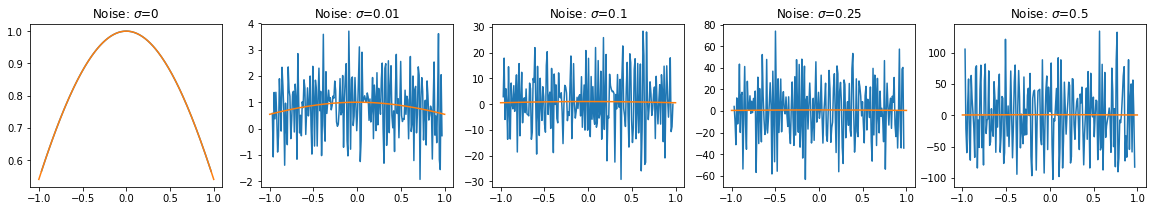

In [212]:
fd = diff.FiniteDifference({'k': 3})
plot_example(fd, x, noisy_sin, np.cos, sigmas)

### Savitzky-Golay Filter
The window size is a hyper-parameter.

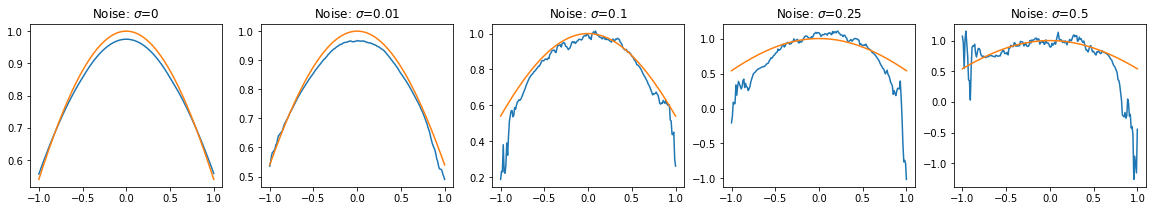

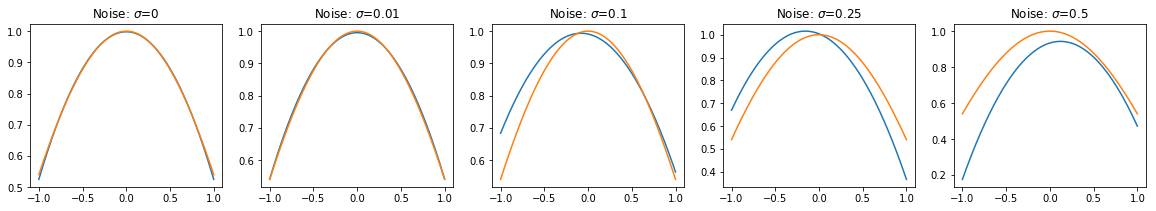

In [211]:
sg = diff.SavitzkyGolay({'left': .5, 'right': .5, 'order': 2})
plot_example(sg, x, noisy_sin, np.cos, sigmas)

sg = diff.SavitzkyGolay({'left': 3, 'right': 3, 'order': 3})
plot_example(sg, x, noisy_sin, np.cos, sigmas)

### Splines
Smoothing is a hyper-parameter. The Spline functions have re-run functionality built-in so cross-validation should take advantage of this. Also, the data may benefit greatly from binning and re-weighting (weights are an available parameter--they change the definition of the loss function).

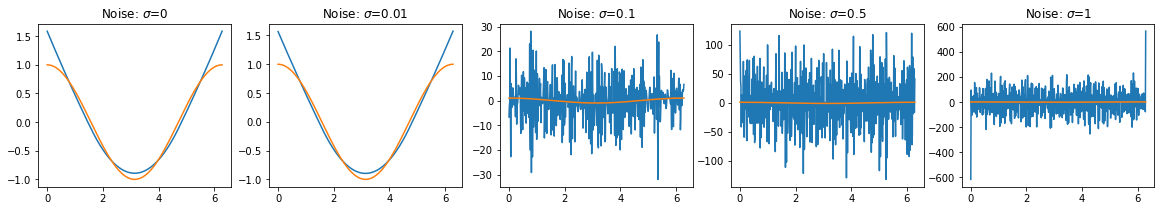

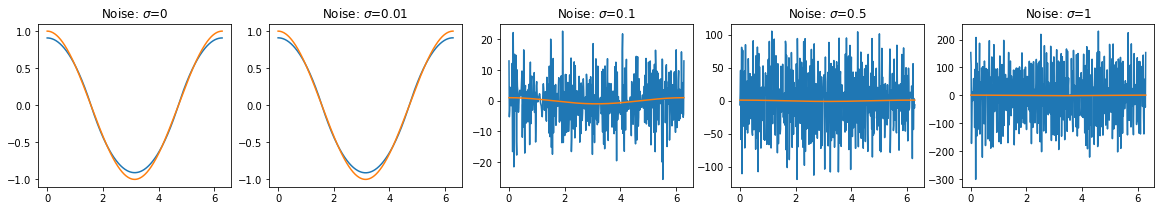

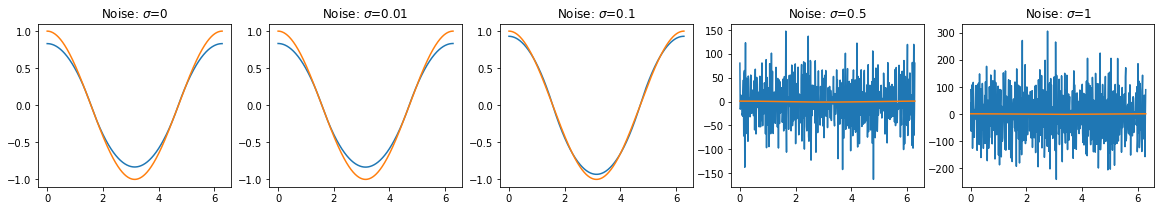

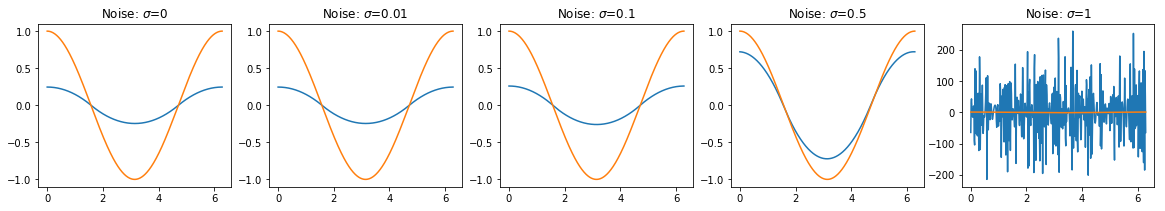

In [181]:
spl = diff.Spline({'smoothing': 1})
plot_example(spl, x, noisy_sin, np.cos, sigmas)
spl = diff.Spline({'smoothing': 1, 'periodic': True})
plot_example(spl, x, noisy_sin, np.cos, sigmas)
spl = diff.Spline({'smoothing': 5, 'periodic': True})
plot_example(spl, x, noisy_sin, np.cos, sigmas)
spl = diff.Spline({'smoothing': 139, 'periodic': True})
plot_example(spl, x, noisy_sin, np.cos, sigmas)

### Spectral method
Add your own filter!

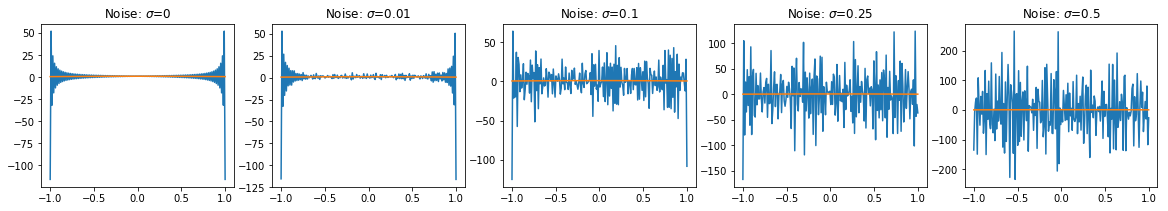

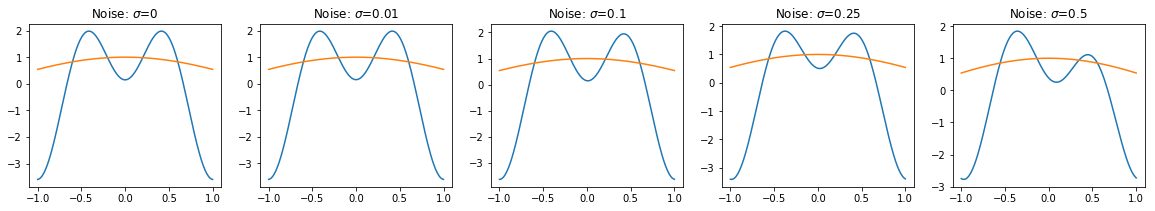

In [177]:
no_filter =  diff.Spectral({})
yes_filter = diff.Spectral({'filter': np.vectorize(lambda f: 1 if abs(f) < 1 else 0)})

plot_example(no_filter, x, noisy_sin, np.cos, sigmas)
plot_example(yes_filter, x, noisy_sin, np.cos, sigmas)

### Total Variational Derivative

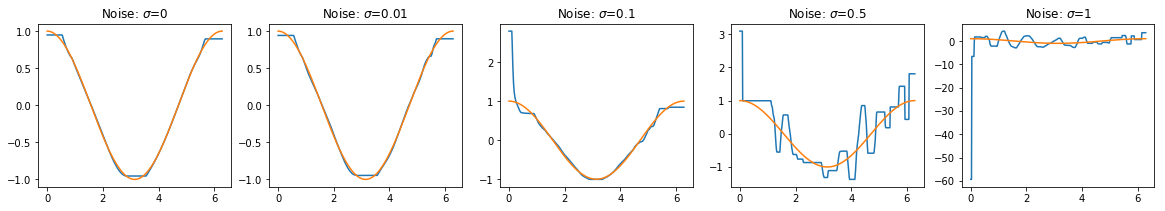

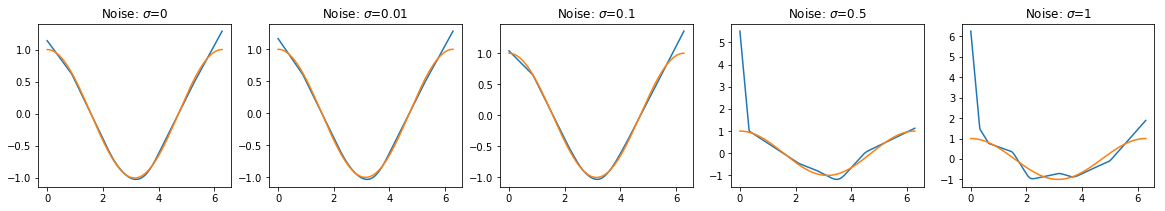

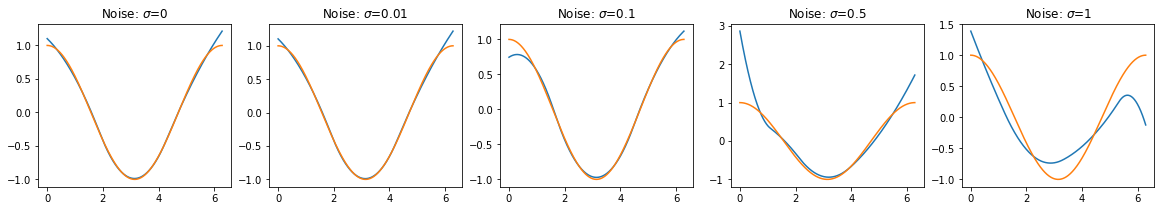

In [201]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    tvd =  diff.TotalVariation({'alpha': 1e-3, 'order': 1,'lasso_params':{'tol': 0.01}})
    plot_example(tvd, x, noisy_sin, np.cos, sigmas)

    tvd =  diff.TotalVariation({'alpha': 1e-3, 'order': 2})
    plot_example(tvd, x, noisy_sin, np.cos, sigmas)

    tvd =  diff.TotalVariation({'alpha': 1e-3, 'order': 3})
    plot_example(tvd, x, noisy_sin, np.cos, sigmas)

## Example 2: Derivative with jump

In [224]:
def noisy_abs(x, sigma):
    '''Sine with gaussian noise.'''
    return np.abs(x) + np.random.normal(loc=0, scale=sigma, size=x.shape)

d_abs = lambda x: x/abs(x)

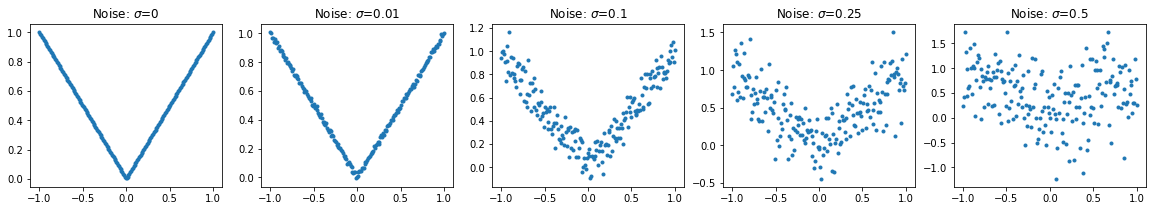

In [225]:
sigmas = [0, 0.01, 0.1, .25, 0.5]
fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])

x = np.linspace(-1, 1, 200)
for axs, s in zip(ax, sigmas): 
    axs.scatter(x, noisy_abs(x, s))
    axs.set_title("Noise: $\sigma$={}".format(s))

### Finite differences

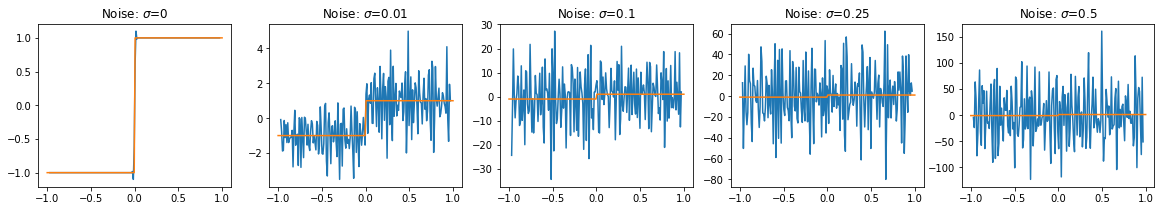

In [216]:
fd = diff.FiniteDifference({'k': 3})
plot_example(fd, x, noisy_abs, d_abs, sigmas)

### Savitzky-Galoy Filter

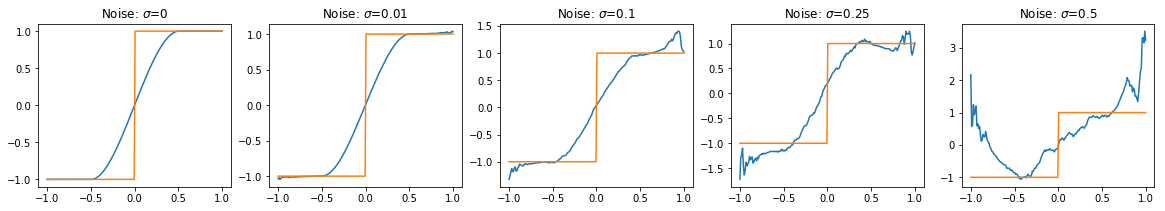

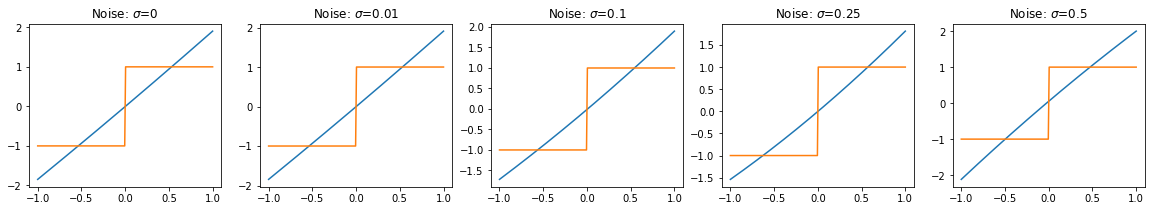

In [217]:
sg = diff.SavitzkyGolay({'left': .5, 'right': .5, 'order': 2})
plot_example(sg, x, noisy_abs, d_abs, sigmas)

sg = diff.SavitzkyGolay({'left': 3, 'right': 3, 'order': 3})
plot_example(sg, x, noisy_abs, d_abs, sigmas)

### Splines

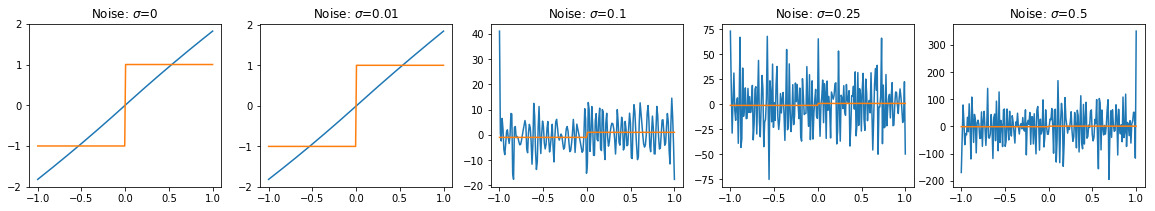

In [222]:
spl = diff.Spline({'smoothing': 1})
plot_example(spl, x, noisy_abs, d_abs, sigmas)

### Spectral Method

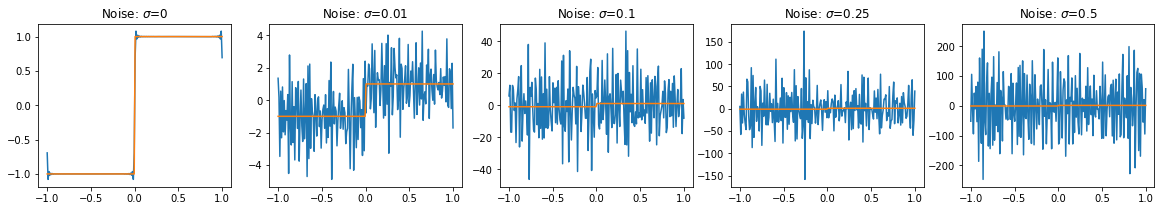

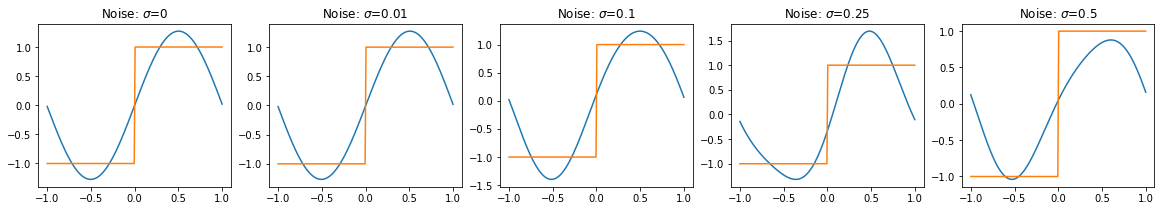

In [226]:
no_filter =  diff.Spectral({})
yes_filter = diff.Spectral({'filter': np.vectorize(lambda f: 1 if abs(f) < 1 else 0)})

plot_example(no_filter, x, noisy_abs, d_abs, sigmas)
plot_example(yes_filter, x, noisy_abs, d_abs, sigmas)

### Total Variational Derivative

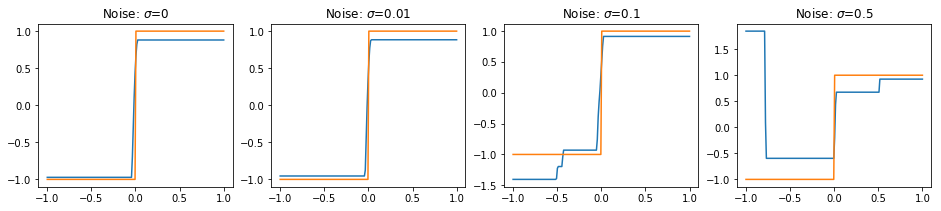

In [249]:
tvd =  diff.TotalVariation({'alpha': 1e-2, 'order': 1, 
                            'lasso_params':{'tol': 0.001}})
plot_example(tvd, x, noisy_abs, d_abs, sigmas)

## Example 3: Lorenz system
Inspect the differentiation of the x-component of the Lorenz oscillator.

### Setup

In [227]:
class lorenz:
    '''Simulate the Lorenz system:
        x'=sigma(y-x)
        y'=Rx-y-xz
        z'=-bz+xy
    '''
    def __init__(self, sigma, R, b, noise=0):
        self.t = np.array([])
        self.x = np.array([])
        self.sigma,self.R,self.b = sigma,R,b
        self.noise = noise
    def f(self, t, x):
        x1,x2,x3 = x
        return [self.sigma*(x2-x1), self.R*x1-x2-x1*x3, -self.b*x3+x1*x2]
    def simulate(self, t0, x0, t_bound, max_step=np.inf):
        self.solver = sp.integrate.RK45(self.f, t0, x0, t_bound, max_step=max_step)
        if self.t.size > 0:
            self.t = np.hstack((self.t, t0))
        else:
            self.t = t0
        if self.x.size > 0:
            self.x = np.hstack((self.x, x0))
        else:
            self.x = x0
        while self.solver.status == 'running':
            self.solver.step()
            self.t = np.hstack((self.t, self.solver.t))
            self.x = np.vstack((self.x, self.solver.y)) + np.random.normal(scale=self.noise)

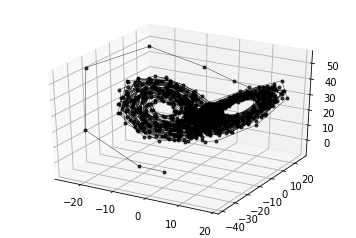

In [228]:
l = lorenz(10, 28, 8/3)
l.simulate(0, -20*np.random.rand(3), 100)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(l.x[:,0], l.x[:,1], l.x[:,2], color='k', marker='.', lw=0.5, alpha=0.75)

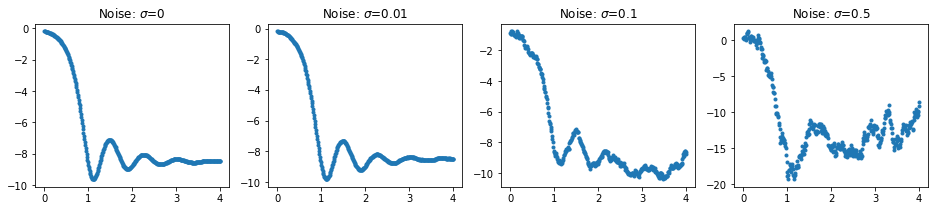

In [229]:
x0 = 2*np.random.rand(3)-1
sigmas = [0, .01, .1, .5]

fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
l_data = {}
l_true = {}
# Note: sigma usage is redundant, sigmas are noise and l.sigma is the lorenz param.
for i, s in enumerate(sigmas):
    l = lorenz(1, 28, 8/3, s)
    l.simulate(0, x0, 4, 0.01)
    l_data[s] = sp.interpolate.interp1d(l.t, l.x[:, 0])
    l_true[s] = sp.interpolate.interp1d(l.t[1:], l.sigma*(l.x[:-1,1]-l.x[:-1,0]), fill_value='extrapolate')
    
    ax[i].scatter(l.t, l.x[:,0])
    ax[i].set_title("Noise: $\sigma$={}".format(s))

def plot_example_2(diff_method, t, data, true, sigmas):
    fig, ax = plt.subplots(1, len(sigmas), figsize=[len(sigmas)*4, 3])
    indices = np.arange(len(t))
    
    for axs, s in zip(ax, sigmas):
        res = list(diff_method.compute_for(t, data[s](t), indices))
        axs.plot(t, res)
        axs.plot(t, true[s](t))
        axs.set_title("Noise: $\sigma$={}".format(s))

### Finite differences

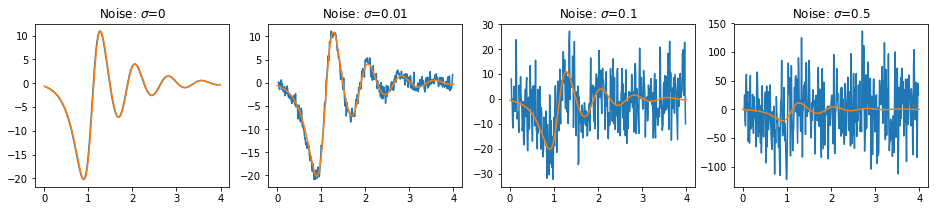

In [230]:
plot_example_2(fd, l.t, l_data, l_true, sigmas)

### Savitzky-Golay Filter

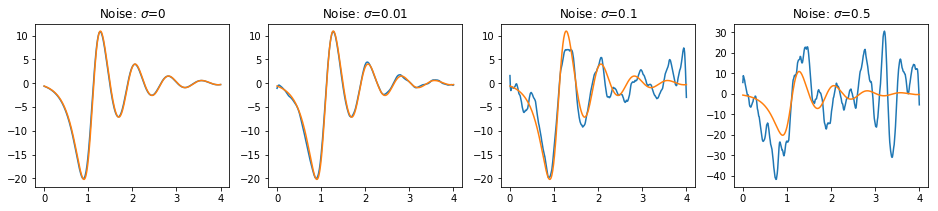

In [231]:
sg = diff.SavitzkyGolay({'left': .2, 'right': .2, 'order': 3})
plot_example_2(sg, l.t, l_data, l_true, sigmas)

### Splines

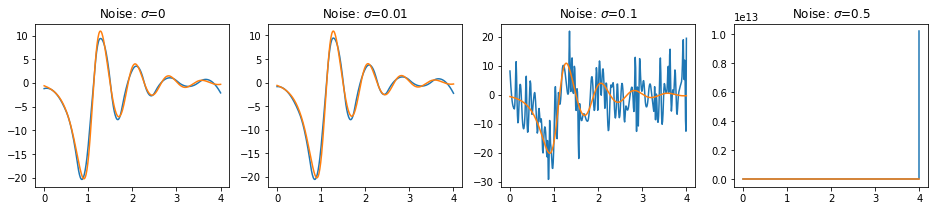

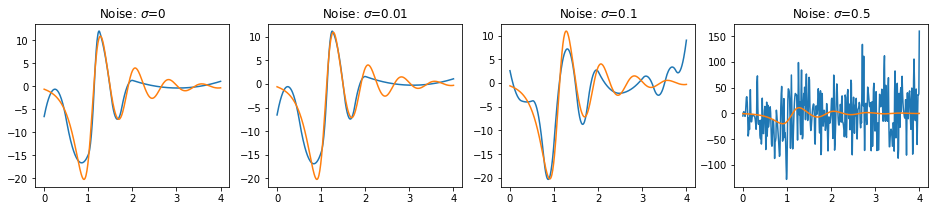

In [232]:
spl = diff.Spline({'smoothing': 1})
plot_example_2(spl, l.t, l_data, l_true, sigmas)
spl = diff.Spline({'smoothing': 10})
plot_example_2(spl, l.t, l_data, l_true, sigmas)

### Spectral method

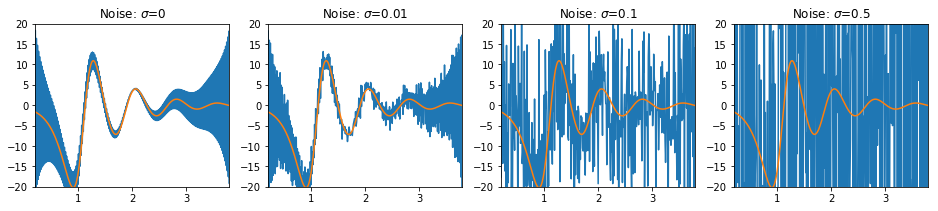

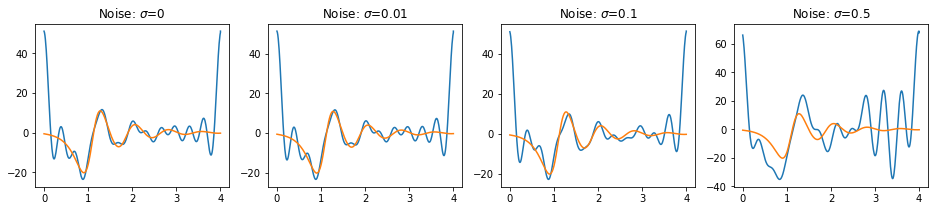

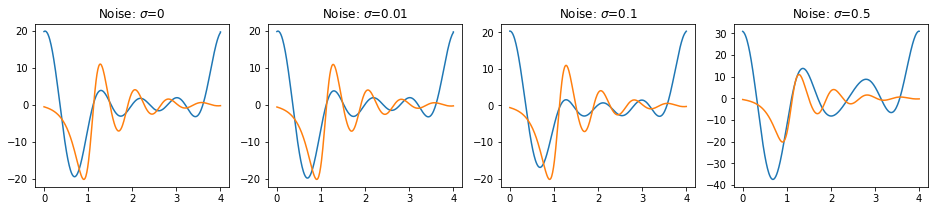

In [233]:
no_filter =  diff.Spectral({})
plot_example_2(no_filter, l.t, l_data, l_true, sigmas)
[iax.set_xlim([.2,3.8]) for iax in plt.gcf().axes]
[iax.set_ylim([-20,20]) for iax in plt.gcf().axes]

yes_filter = diff.Spectral({'filter': np.vectorize(lambda f: 1 if abs(f) < 3 else 0)})
plot_example_2(yes_filter, l.t, l_data, l_true, sigmas)

yes_filter = diff.Spectral({'filter': np.vectorize(lambda f: 1 if abs(f) < 1 else 0)})
plot_example_2(yes_filter, l.t, l_data, l_true, sigmas)

### Total Variational Derivative

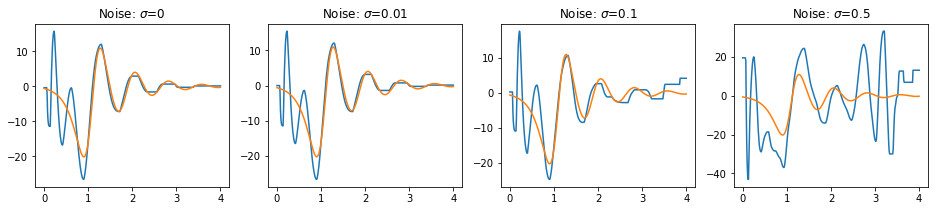

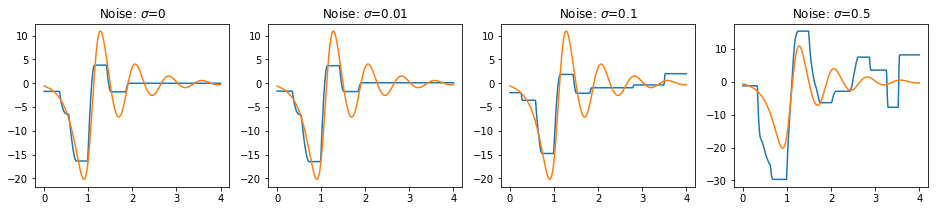

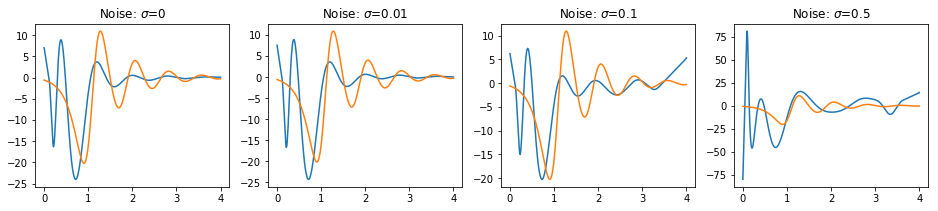

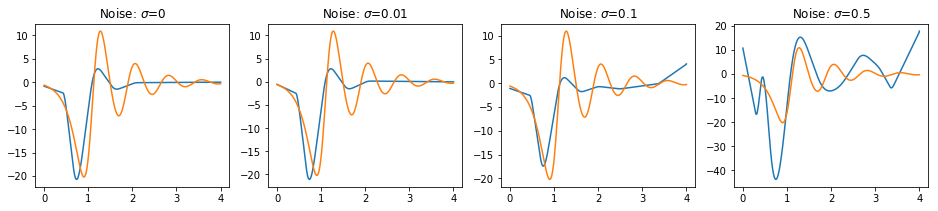

In [248]:
tvd =  diff.TotalVariation({'alpha': 1e-3, 'order': 1})
plot_example_2(tvd, l.t, l_data, l_true, sigmas)

tvd =  diff.TotalVariation({'alpha': 1e-2, 'order': 1})
plot_example_2(tvd, l.t, l_data, l_true, sigmas)

tvd =  diff.TotalVariation({'alpha': 1e-4, 'order': 2})
plot_example_2(tvd, l.t, l_data, l_true, sigmas)

tvd =  diff.TotalVariation({'alpha': 1e-3, 'order': 2})
plot_example_2(tvd, l.t, l_data, l_true, sigmas)